# GPU Check

In [1]:
#!pip uninstall tensorflow
#!pip uninstall tensorflow-gpu
#!pip install --upgrade --force-reinstall tensorflow-gpu
#!pip install tensorflow
#!pip install tensorflow-directml-plugin
import tensorflow as tf

In [2]:
print('TensorFlow Version: ' + tf.__version__)
!pip show tensorflow

TensorFlow Version: 2.10.0
Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\skyxt\anaconda3\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [3]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Packages and Environmnet

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, Adagrad
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf


import matplotlib.pyplot as plt
from matplotlib.image import imread
#!pip install opencv-python
import cv2

import os
import warnings
warnings.filterwarnings('ignore')

import sys

#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

sys.path.append('InceptionV3')
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.applications import VGG16

In [6]:
import time
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

# Run this line above to install basic packages

In [7]:
###### RUN THIS CELL ABOVE ######

# View the data (Simple data with from one material)

In [8]:
# Create a function to see some images 

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,5)
    
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

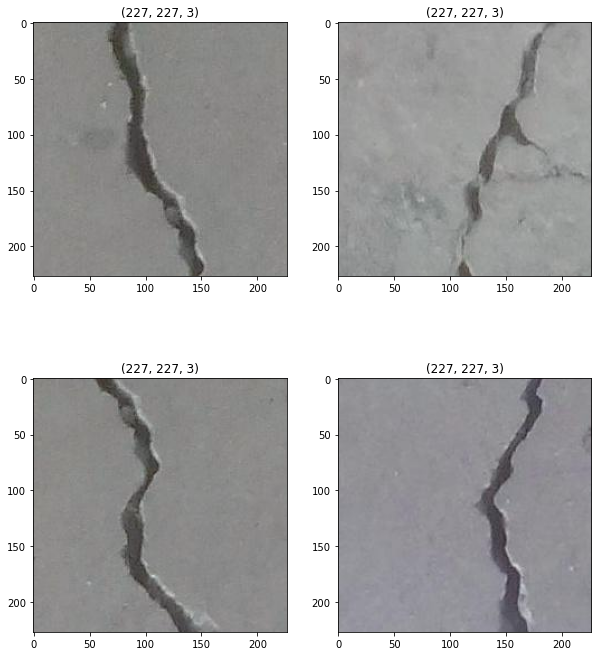

In [9]:
load_images_from_folder("data/Positive")

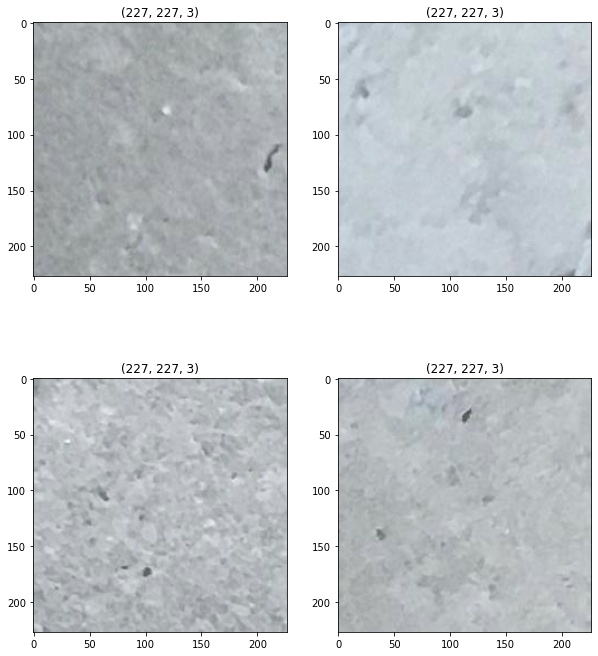

In [10]:
load_images_from_folder("data/Negative")

# Creat Dataset

In [11]:
%%time
labels = ['Negative', 'Positive']
img_size = 150
def read_images(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Dataset = read_images('data')

CPU times: total: 17.2 s
Wall time: 2min 38s


<AxesSubplot:ylabel='count'>

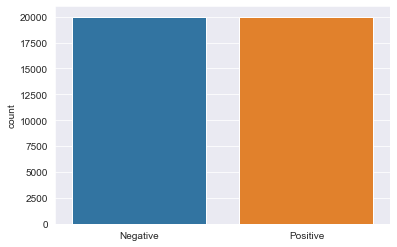

In [12]:
# find out the number of images in each class
l = []
for i in Dataset:
    if(i[1] == 0):
        l.append("Negative")
    else:
        l.append("Positive")
sns.set_style('darkgrid')
sns.countplot(l)

In [13]:
# make x as features and y as labels
x = []
y = []

for feature, label in Dataset:
    x.append(feature)
    y.append(label)

# Normalize the data
x = np.array(x) / 255
x = x.reshape(-1, img_size, img_size, 1)
y = np.array(y)

In [14]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [15]:
# print length of train and test data
print("Length of train data: ", len(x_train))
print("Length of test data: ", len(x_test))

Length of train data:  32000
Length of test data:  8000


# Use Convolutional neural networks (CNN)

In [16]:
# create the sequential model
model = Sequential()

model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = x.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [17]:
# train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1000/1000 [==============================] - 35s 34ms/step - loss: 0.1030 - accuracy: 0.9564 - val_loss: 0.0360 - val_accuracy: 0.9878
Epoch 2/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0446 - accuracy: 0.9856 - val_loss: 0.0260 - val_accuracy: 0.9919
Epoch 3/10
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0299 - accuracy: 0.9913 - val_loss: 0.0121 - val_accuracy: 0.9964
Epoch 4/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0268 - accuracy: 0.9921 - val_loss: 0.0102 - val_accuracy: 0.9970
Epoch 5/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.0135 - val_accuracy: 0.9963
Epoch 6/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0116 - val_accuracy: 0.9970
Epoch 7/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0108 -

(0.94, 1.0)

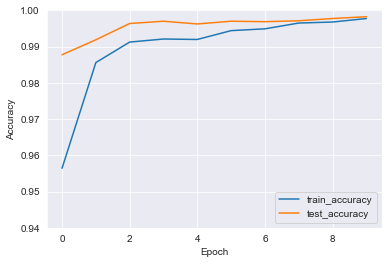

In [26]:
# visualize the model
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# adjust ylabel range to 0.98 to 1
plt.ylim([0.94, 1])

250/250 - 2s - loss: 0.0063 - accuracy: 0.9983 - 2s/epoch - 8ms/step
250/250 [==============================] - 2s 7ms/step


Text(0.5, 25.0, 'Predicted label')

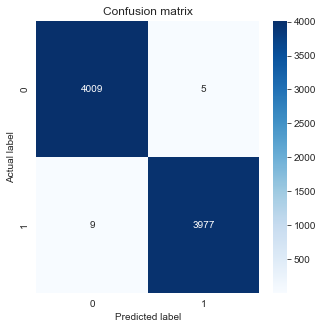

In [20]:
# evaluate the model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

# make predictions
y_pred = model.predict(x_test)

# plot the confusion matrix
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
plt.figure(figsize=(5,5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [21]:
# print the classification report
print(classification_report(y_test, np.argmax(y_pred, axis=1), target_names = ['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4014
    Positive       1.00      1.00      1.00      3986

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [29]:
# get the precision, recall, f1-score and support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, np.argmax(y_pred, axis=1), average='macro')

print('For testing dataset:')

# print the precision, recall, f1-score and support
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

For testing dataset:
precision: 0.9982522146073458
recall: 0.9982482285407996
fscore: 0.998249971999552


In [30]:
# print traing and testing accuracy
print("Training Accuracy: {:.4f}".format(history.history['accuracy'][-1]))
print("Testing Accuracy: {:.4f}".format(test_acc))

Training Accuracy: 0.9978
Testing Accuracy: 0.9983


In [31]:
# save the model
model.save('model.cnn')

INFO:tensorflow:Assets written to: model.cnn\assets


INFO:tensorflow:Assets written to: model.cnn\assets
